<a href="https://colab.research.google.com/github/Junoflows/Hands_on_ML/blob/main/Chapter_15_RNN%EA%B3%BC_CNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%B4_%EC%8B%9C%ED%80%80%EC%8A%A4_%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설정    

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Chapter 15 RNN과 CNN을 사용해 시퀀스 처리하기

## 15.0 RNN 소개

시계열 데이터 분석 활용

임의의 길이를 갖는 시퀀스 처리
+ 문장, 문서, 오디오 샘플

자동번역, STT 같은 자연어처리 분야에 매우 유용

RNN 의 주요 난제
+ 불안정한 그레디언트
+ 단기기억 문제

## 15.1 순환 뉴런과 순환 층

+ Feedforward 신경망 : 활성화 신호가 입력층에서 출력층 한 방향으로만 흐르는 신경망
+ RNN 도 비슷하게 작동하지만 후방향으로 전달하여 학습결과를 순환시킴

##### 순환뉴런
+ 입력을 받아 출력을 만든 후 자신에게 출력결과를 전달
+ '시간에 따라 네트워크를 펼쳤다'

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-01a.png' width =50% >

##### 순환순환층
+ 순환뉴런으로 구성된 층

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-02a.png' width = 50%>

#### 하나의 샘플에 대한 순환층의 출력
+ 가중치 행렬
  + $W_x$ : 현재 타임스텝의 입력에 대한 연결가중치 행렬
  + $W_y$ : 이전 타임스텝의 출력에 대한 연결가중치 행렬



$y_{(t)} = \phi(W_x^T x_{(t)} + W_y^T y_{(t-1)} + b)$


미니배치에 대한 순환층의 출력


$Y_{(t)} = \phi(X_{(t)} W_x + Y_{(t-1)} W_y + b) \\
= \phi \begin{pmatrix} X_{(t)}Y_{(t-1)} \end{pmatrix} \begin{pmatrix} W_x \\ W_y \end{pmatrix} + b
$

### 15.1.1 메모리 셀

메모리 셀
+ 타임 스텝에 걸쳐서 특정 상태를 보존하는 신경망의 구성요소
+ 하나의 순환 뉴런(층) - 10 스텝 정도의 짧은 패턴을 학습하는 기본적인 셀
+ LSTM셀, GRU셀 - 장단기 기억 셀

상태 h(t) : 타임스텝 t에서의 셀의 상태 <br/>
$h(t) = f(h(t-1), x(t))$


<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-03.png' width = 50%>

### 15.1.2 입력과 출력 시퀀스

+ 목적에 따라 입력/출력 데이터의 형식을 벡터 또는 시퀀스로 지정할 수 있음

#### seq-to-seq
+ 입력 : 시퀀스
+ 출력 : 시퀀스
+ 시계열 데이터 활용에 유용

<img src ='https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-04a.png' width = 50%>

#### seq-to-vector
+ 입력 : 시퀀스
+ 출력 : 벡터


<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-04b.png' width = 50% >

#### vector-to-seq
+ 입력: 벡터
+ 출력: 시퀀스

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-04c.png' width = 50%>

#### encoder-decoder
+ 인코더와 디코더의 조합을 사용하는 이중단계모델
+ 인코더 : seq-to-vector 신경망
+ 디코더 : vector-to-seq 신경망
+ 언어 번역

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-04d.png' width =50%>

## 15.2 RNN 훈련

+ BPTT(backpropagation through time) : 타임스텝을 통과하는 역전파
+ 가중치 $W$와 편향 $b$ 가 타임스텝에 의존하지 않음
  + 모든 타임스텝에 대해 일관되게 작동

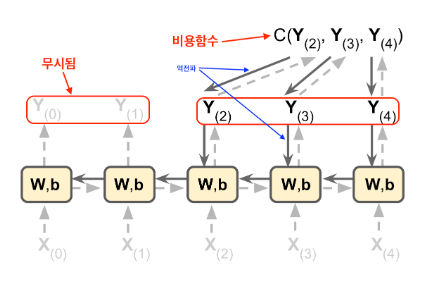

## 15.3 시계열 예측하기

단변량 시계열
+ 타임스텝 마다 하나의 값을 가지는 시퀀스
+ 웹사이트의 시간 당 접속자 수, 도시의 날짜별 온도 등

다변량 시계열
+ 타임스텝 마다 여러 값을 가지는 시퀀스
+ 회사의 수입, 부채

@ 예측, 결측치 대체로 활용

#### 예제
+ 3개의 단변량 시계열
+ 타임스텝 50개
+ X로 표시된 값 예측

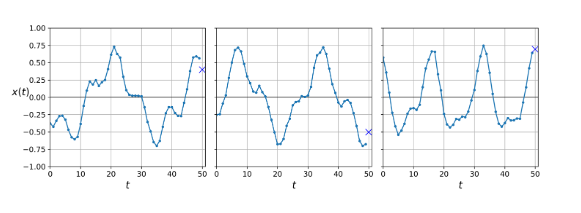

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #  파도 곡선 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #  파도 속선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   #  잡음
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# 훈련, 검증, 테스트 세트 생성
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### 15.3.1 기준 성능

단순 예측(naive forecasting)
+ 시계열의 마지막 값을 예측값으로 사용

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

선형회귀 예측
+ 완전연결 네트워크를 사용

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
    ])

model.compile(loss="mse", optimizer="adam")

In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data = (X_valid, y_valid))

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0046


0.004631077870726585

### 15.3.2 간단한 RNN 구현하기
SimpleRNN 층
+ 1개의 순환 뉴런을 갖는 순환층 1개로 구성된 모델
+ 활성화 함수 : tanh
+ 모든 시계열 샘플 데이터를 동시에 처리

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [ ]:
model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0114


0.011372195556759834

@ 선형 모델은 파라미터 51, 심플 RNN은 3개

### 15.3.3 심층 RNN


셀을 여러 층으로 쌓은 RNN

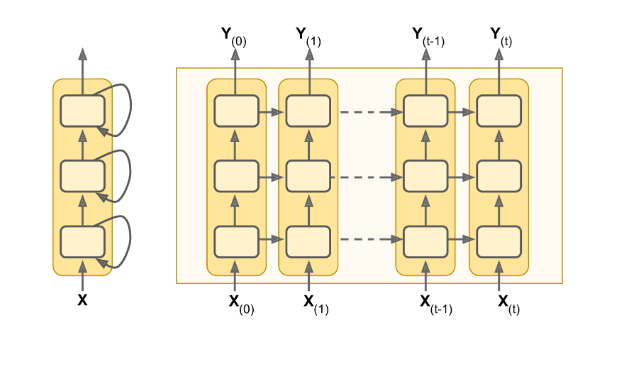

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

In [ ]:
model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0030


0.003028496401384473

### 15.3.4 여러 타임스텝 미래 예측

@ 지금까지 한 타임스텝 미래만 예측 <br/>
+ 한 타임스텝 예측을 원하는 만큼 반복
+ 여러 타임스텝의 값을 동시에 예측

#### 한 타임스텝 예측 반복
+ 이미 훈련된 모델을 이용하여 한 타임스텝 예측
+ 예측 결과를 실제 값처럼 사용하여 동일한 과정 반복
+ 미래 예측이 반복될 수록 정확도 떨어지지만 경우에 따라 잘 작동할 수 있음

In [ ]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:]

In [ ]:
np.mean(tf.keras.losses.mean_squared_error(series[:, -10:, :], y_pred))

0.1024339

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-12.png' width = 50%>

#### 여러 타임스텝 값 동시 예측1

+ 마지막 예측 과정에서 미래 타임스텝 10개의 값을 예측하는 것으로 변경
+ 여전히 seq-to-vector 모델 사용

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
    ])

model.compile(loss="mse", optimizer="adam")

In [ ]:
model.fit(X_train, Y_train, epochs = 20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 17ms/step - loss: 0.0467 - val_loss: 0.0321
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0275 - val_loss: 0.0222
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0198 - val_loss: 0.0161
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0138 - val_loss: 0.0156
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0124 - val_loss: 0.0131
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0120 - val_loss: 0.0136
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0111 - val_lo

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0095


0.00950534176081419

#### 성능 비교 (MSE)
+ 단순 예측 : 0.2
+ 선형회귀 예측 : 0.01
+ 심층 RNN : 0.009

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-13.png' width = 50%>

#### 여러 타임스텝 값 동시 예측2
+ 전체 타임스텝에서 미래 타임스텝 10개의 값을 예측하도록 설정
+ seq-to-seq 모델 형식으로 변경

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# 각 타임스텝에 대한 타깃값을 10개씩 설정
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

In [ ]:
model.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0183 - last_time_step_mse: 0.0069


[0.018321651965379715, 0.006885050795972347]

@ 짧은 시퀀스에서는 심층 RNN이 잘 동작하지만 길어지면 잘 동작하지 않음

## 15.4 긴 시퀀스 다루기

심층 RNN 훈련 시 문제점
+ 그레디언트 소실 및 복주 문제
+ 긴 훈련시간 또는 불안정한 훈련
+ 초기 정보 소실

### 15.4.1 불안정한 그레디언트 문제 다루기

+ 좋은 가중치 초기화, 빠른 옵티마이저, 드롭아웃 등 활용
+ ReLU 같은 수렴하지 않는 활성화 함수는 RNN을 더 불안정하게 함
  + 그레디언트 폭주

+ 배치정규화는 효과적이지 않음
+ 층 정규화는 효과적

#### 층 정규화
+ 특성 차원의 정규화
+ 샘플에 독립적으로 타임스템마다 동적으로 필요한 계산을 할 수 있음

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

### 15.4.2 단기기억 문제 해결하기


#### LSTM 셀
+ 1997년 소개
+ SimpleRNN 층 대신 LSTM 층 사용

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-15.png' width = 50%>

$i_{(t)} = \sigma(W_{xi} x_{(t)} + W_{hi} h_{(t-1)} + b_i)$ <br/>
$f_{(t)} = \sigma(W_{xf} x_{(t)} + W_{hf} h_{(t-1)} + b_f)$ <br/>
$o_{(t)} = \sigma(W_{xo} x_{(t)} + W_{ho} h_{(t-1)} + b_o)$ <br/>
$g_{(t)} = \tanh(W_{xg} x_{(t)} + W_{hg} h_{(t-1)} + b_g)$ <br/>
$c_{(t)} = f_{(t)} \odot c_{(t-1)} + i_{(t)} \odot g_{(t)}$ <br/>
$y_{(t)} = h_{(t)} = o_{(t)} \odot \tanh(c_{(t)})
$

#### GRU 셀
+ 2014년 소개
+ LSTM 셀의 간소화 버전으로 성능 유사

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-16.png' width =50%>

$z_{(t)} = \sigma(W_{xz} x_{(t)} + W_{hz} h_{(t-1)} + b_z)$ <br/>
$r_{(t)} = \sigma(W_{xr} x_{(t)} + W_{hr} h_{(t-1)} + b_r)$ <br/>
$g_{(t)} = \tanh(W_{xg} x_{(t)} + W_{hg} (r_{(t)} \odot h_{(t-1)}) + b_g)$ <br/>
$h_{(t)} = z_{(t)} \odot h_{(t-1)} + (1 - z_{(t)}) \odot g_{(t)}$ <br/>


#### GRU 셀과 합성곱 층을 사용한 시퀀스 처리

+ 1D 합성곱 층으로 입력값을 처리한 후 GRU 셀 활용
+ 2 이상의 stride를 사용하여 시퀀스 길이를 줄이면서 핵심정보만 GRU 셀에 전달

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

#### WAVENET

+ 2016년에 소개됨
+ 네트워크 층마다 팽창비율을 2배로 늘리는 1D 합성곱 층을 쌓아올림
+ 팽창비율 : 각 뉴런의 입력이 떨어져 있는 간격

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch15/homl15-17.png' width = 50%>

+ TTS 작업, 음악 오디오 샘플 생성 등 오디오 문제에서 좋은 성능을 발휘
+ LSTM, GRU 보다 훨씬 긴 시퀀스를 다룰 수 있음